# Выявление закономерностей, влияющих на успешность игры на декабрь 2016 года.

Задача: нам нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании для интернет-магазина "Стримчик".

Перед нами данные до 2016 года. Нужно спрогнозировать продажи на 2017 год по эти данным.

## Ознакомление с данными <a name="1"></a>

In [1]:
# импортируем основные библиотеки для работы
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
import numpy as np

In [2]:
df = pd.read_csv('/datasets/games.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Названия столбцов стоит привести к нижнему регистру для удобства. 
Дату выпуска для удобства отображения года и работы со столбцом стоит привести к формату int. 
Продажи оставим как есть, они в миллионах, удобно смотреть на короткие цифры.
Рейтинг юзеров, лучше перевести во float.

In [3]:
df.duplicated().sum()

0

Дублей нет.

In [4]:
df['Critic_Score'].value_counts()

70.0    256
71.0    254
75.0    245
78.0    240
73.0    238
       ... 
20.0      3
17.0      1
22.0      1
13.0      1
21.0      1
Name: Critic_Score, Length: 82, dtype: int64

In [5]:
df['User_Score'].value_counts()

tbd    2424
7.8     324
8       290
8.2     282
8.3     254
       ... 
2.3       2
0.6       2
0.3       2
9.7       1
0         1
Name: User_Score, Length: 96, dtype: int64

In [6]:
df['Rating'].value_counts()

E       3990
T       2961
M       1563
E10+    1420
EC         8
RP         3
K-A        3
AO         1
Name: Rating, dtype: int64

In [7]:
df.columns = df.columns.str.lower()

In [8]:
df.isna().sum()

name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         6701
rating             6766
dtype: int64

Очень много пропущенных значений в столбцах с рейтингами, далее год выпуска, имя игры и жанр.
Возможно удасться заменить пропущенные рейтинги и год выпуска по названию игры, если такие данные будут у игры на другой платформе.
Возможно пустые жанр и имя игры находятся в одной строке. Проверим.

In [9]:
df.loc[(df['name'].isna()) & (df['genre'].isna())]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


Предположение верно. Имя игры и жанр неизвестны, и восстановить их не получится. Тем более всего две строки, они не повлияют на результат. Я думаю, что не стоит их удалять, так как они будут участвовать подсчете продаж по регионам. Оставим как есть.

In [10]:
df

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16710,Samurai Warriors: Sanada Maru,PS3,2016.0,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16711,LMA Manager 2007,X360,2006.0,Sports,0.00,0.01,0.00,0.00,NaN,NaN,NaN
16712,Haitaka no Psychedelica,PSV,2016.0,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16713,Spirits & Spells,GBA,2003.0,Platform,0.01,0.00,0.00,0.00,NaN,NaN,NaN


Так же стоит привести столбцы "название игры", "платформа", "жанр" и "рейтинг" к нижнему регистру.

## Подготовка данных <a name="2"></a>

•	Приведем к нижнему регистру колонки "название игры", "платформа", "жанр" и "рейтинг".
•	Обработаем пропуски.
•	Преобразуем данные в нужные типы.
•	Посчитаем суммарные продажи во всех регионах.

In [11]:
df['name'] = df['name'].str.lower()
df['platform'] = df['platform'].str.lower()
df['genre'] = df['genre'].str.lower()
df['rating'] = df['rating'].str.lower()
df

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,wii sports,wii,2006.0,sports,41.36,28.96,3.77,8.45,76.0,8,e
1,super mario bros.,nes,1985.0,platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,mario kart wii,wii,2008.0,racing,15.68,12.76,3.79,3.29,82.0,8.3,e
3,wii sports resort,wii,2009.0,sports,15.61,10.93,3.28,2.95,80.0,8,e
4,pokemon red/pokemon blue,gb,1996.0,role-playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16710,samurai warriors: sanada maru,ps3,2016.0,action,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16711,lma manager 2007,x360,2006.0,sports,0.00,0.01,0.00,0.00,NaN,NaN,NaN
16712,haitaka no psychedelica,psv,2016.0,adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16713,spirits & spells,gba,2003.0,platform,0.01,0.00,0.00,0.00,NaN,NaN,NaN


Посмотрим сколько уникальных игр есть в таблице:

In [12]:
df['name'].value_counts()

need for speed: most wanted    12
madden nfl 07                   9
ratatouille                     9
lego marvel super heroes        9
fifa 14                         9
                               ..
daisy fuentes pilates           1
my make-up                      1
army corps of hell              1
ms. pac-man: maze madness       1
high heat baseball 2002         1
Name: name, Length: 11559, dtype: int64

Рассмотрим ближе игры чаще встречаемые в наших данных.

In [13]:
display(df[df['name'] == 'need for speed: most wanted'])
display(df[df['name'] == 'fifa 14'])
display(df[df['name'] == 'ratatouille'])
display(df[df['name'] == 'madden nfl 07'])
display(df[df['name'] == 'lego marvel super heroes'])

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
253,need for speed: most wanted,ps2,2005.0,racing,2.03,1.79,0.08,0.47,82.0,9.1,t
523,need for speed: most wanted,ps3,2012.0,racing,0.71,1.46,0.06,0.58,NaN,NaN,NaN
1190,need for speed: most wanted,x360,2012.0,racing,0.62,0.78,0.01,0.15,83.0,8.5,t
1591,need for speed: most wanted,x360,2005.0,racing,1.00,0.13,0.02,0.10,83.0,8.5,t
1998,need for speed: most wanted,xb,2005.0,racing,0.53,0.46,0.00,0.05,83.0,8.8,t
2048,need for speed: most wanted,psv,2012.0,racing,0.33,0.45,0.01,0.22,NaN,NaN,NaN
3581,need for speed: most wanted,gc,2005.0,racing,0.43,0.11,0.00,0.02,80.0,9.1,t
5972,need for speed: most wanted,pc,2005.0,racing,0.02,0.23,0.00,0.04,82.0,8.5,t
6273,need for speed: most wanted,wiiu,2013.0,racing,0.13,0.12,0.00,0.02,NaN,NaN,NaN
6410,need for speed: most wanted,ds,2005.0,racing,0.24,0.01,0.00,0.02,45.0,6.1,e


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
126,fifa 14,ps3,2013.0,sports,0.78,4.24,0.07,1.37,86.0,4.3,e
271,fifa 14,x360,2013.0,sports,0.92,2.89,0.01,0.40,84.0,4.2,e
469,fifa 14,ps4,2013.0,sports,0.61,1.85,0.11,0.44,87.0,6.3,e
1753,fifa 14,xone,2013.0,sports,0.41,0.66,0.00,0.09,88.0,5.8,e
4699,fifa 14,psv,2013.0,sports,0.08,0.23,0.01,0.09,NaN,1.8,e
4809,fifa 14,pc,2013.0,sports,0.01,0.36,0.00,0.03,87.0,4.6,e
4985,fifa 14,wii,2013.0,sports,0.00,0.36,0.00,0.02,NaN,4.3,e
6871,fifa 14,3ds,2013.0,sports,0.00,0.22,0.00,0.01,NaN,NaN,NaN
7875,fifa 14,psp,2013.0,sports,0.00,0.15,0.00,0.04,NaN,3.4,e


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
1598,ratatouille,ds,2007.0,action,0.49,0.62,0.0,0.14,NaN,NaN,NaN
2442,ratatouille,ps2,2007.0,action,0.31,0.00,0.0,0.53,65.0,8,e
3069,ratatouille,psp,2007.0,action,0.22,0.27,0.0,0.16,64.0,7.1,e
3902,ratatouille,ps3,2007.0,action,0.09,0.32,0.0,0.10,55.0,4.8,e
3948,ratatouille,wii,2007.0,action,0.43,0.03,0.0,0.04,62.0,6.7,e
6398,ratatouille,x360,2007.0,action,0.23,0.02,0.0,0.02,56.0,tbd,e
7681,ratatouille,gba,2007.0,action,0.14,0.05,0.0,0.00,65.0,tbd,e
9015,ratatouille,gc,2007.0,action,0.11,0.03,0.0,0.00,60.0,5.6,e
14514,ratatouille,pc,2007.0,action,0.01,0.01,0.0,0.00,NaN,7.9,e


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
241,madden nfl 07,ps2,2006.0,sports,3.63,0.24,0.01,0.61,84.0,8.2,e
972,madden nfl 07,x360,2006.0,sports,1.66,0.00,0.01,0.13,80.0,6,e
2035,madden nfl 07,xb,2006.0,sports,0.97,0.03,0.00,0.03,83.0,8.7,e
2479,madden nfl 07,psp,NaN,sports,0.77,0.03,0.00,0.04,78.0,6.6,e
3229,madden nfl 07,gc,2006.0,sports,0.48,0.13,0.00,0.02,82.0,9.2,e
3838,madden nfl 07,ps3,2006.0,sports,0.47,0.00,0.01,0.04,76.0,4.2,e
4006,madden nfl 07,wii,2006.0,sports,0.46,0.00,0.00,0.04,81.0,8,e
7372,madden nfl 07,ds,2006.0,sports,0.20,0.00,0.00,0.02,70.0,6.5,e
14889,madden nfl 07,gba,2006.0,sports,0.02,0.01,0.00,0.00,68.0,9.3,e


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
730,lego marvel super heroes,x360,2013.0,action,1.24,0.79,0.00,0.19,80.0,7.6,e10+
945,lego marvel super heroes,ps3,2013.0,action,0.77,0.76,0.01,0.29,82.0,7.9,e10+
1139,lego marvel super heroes,ps4,2013.0,action,0.59,0.76,0.01,0.26,83.0,7.7,e10+
1959,lego marvel super heroes,xone,2013.0,action,0.61,0.35,0.00,0.09,NaN,6.8,e10+
2313,lego marvel super heroes,3ds,2013.0,action,0.42,0.36,0.04,0.07,61.0,5.2,e10+
2778,lego marvel super heroes,wiiu,2013.0,action,0.31,0.35,0.02,0.06,82.0,8,e10+
3876,lego marvel super heroes,psv,2013.0,action,0.11,0.29,0.00,0.11,NaN,NaN,NaN
5054,lego marvel super heroes,ds,2013.0,action,0.22,0.13,0.00,0.03,NaN,4.8,e10+
8369,lego marvel super heroes,pc,2013.0,action,0.04,0.12,0.00,0.01,78.0,8.1,e10+


Из просмотренных пяти игр, год выпуска и рейтинг отличается только в одной игре. Так что, отсутствующие значения можно частично заполнить по названию игры. Рейтинг юзеров и критиков мы оставим как есть, ведь игра, вышедшая на одной консоли и показавшая очень высокий рейтинг, на другой консоли может быть оценена очень низко. Это очень субъективные оценки. А возрастной рейтинг заполним с помощью словаря "название игры-рейтинг".

In [14]:
# получим список уникальных игр, которые в таблице повторяются больше одного раза.
games_unique = df.pivot_table(index='name', values='na_sales', aggfunc='count').reset_index()
games_unique = games_unique[games_unique['na_sales'] > 1]
games_unique = games_unique['name'].tolist()
print('Количество уникальных игр, повторяющихся больше 1 раза:', len(games_unique))

Количество уникальных игр, повторяющихся больше 1 раза: 2805


In [15]:
# заполним ячейки с пропущенным годом выпуска игры
for game in games_unique:
    game_year = df[(df['name'] == game) & ~(df['year_of_release'].isna())]['year_of_release'].max()
    df.loc[(df['name'] == game) & (df['year_of_release'].isna()), 'year_of_release'] = game_year

Избавимся от значений "tbd" в рейтинге юзеров. Буквы tba означают to be announced. Перевод простой — «будет объявлено дополнительно». Из этой же категории еще две аббревиатуры — tbc (to be confirmed) и tbd (to be determined). Перевод, соответственно, такой: «будет утверждено» и «будет определено». то есть игры, у которых пока нет рейтинга игроков. И судя по начальным данным значение "0" в этой колонке только одно.

In [16]:
df.loc[df['user_score'] == 'tbd', 'user_score'] = 0

In [17]:
# создадим словарь "название игры-рейтинг", возьмем только те игры, где есть рейтинг
game_rating_dict = dict(zip(df[~(df['rating'].isna())]['name'], df[~(df['rating'].isna())]['rating']))
print('Длина словаря "название игры - рейтинг":', len(game_rating_dict))

Длина словаря "название игры - рейтинг": 6066


In [18]:
# заполним пропущенный рейтинг из словаря
df.loc[df['rating'].isna(), 'rating'] = df.loc[df['rating'].isna()]['name'].map(game_rating_dict)
df.isna().sum()

name                  2
platform              0
year_of_release     146
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         6701
rating             6329
dtype: int64

Мы заполнили 123 пропуска в колонке год выпуска и 437 в колонке возрастной рейтинг. 

Интересно как зависит рейтинг критиков от жанра игр.

In [19]:
df.pivot_table(index='genre', values='critic_score', aggfunc=['mean', 'median', 'std', 'min', 'max', 'var'])

,mean,median,std,min,max,var
,critic_score,critic_score,critic_score,critic_score,critic_score,critic_score
genre,,,,,,
action,66.629101,68.0,14.206877,19.0,98.0,201.835362
adventure,65.331269,66.0,13.920756,17.0,93.0,193.787435
fighting,69.217604,72.0,14.280079,23.0,98.0,203.920670
misc,66.619503,69.0,14.152649,19.0,93.0,200.297473
platform,68.058350,69.0,13.213760,19.0,97.0,174.603443
puzzle,67.424107,70.0,12.735444,25.0,90.0,162.191524
racing,67.963612,69.0,14.248234,13.0,96.0,203.012169
role-playing,72.652646,74.0,11.999835,35.0,96.0,143.996029


Игры с минимальным рейтингом - это гонки и приключения. Максимального рейинга критиков (98) смогли добиться игры таких жанров как экшн, файтинг и спортивные игры. Так как больше 40-50% данных с рейтингами юзеров и критиков пропущены, то заменив их на медианные значения мы можем исказить картину, так как в итоге получится 40-50% медиан в данных. Так как нулей в данных нет, то заменим пропущенные значения в этих столбцах на нули.
Что же касается возрастного рейтинга, то заменим наны на "un" - unknown.
Год игры без парсинга восстановить не удасться, заменим наны в столбце год на "2033".

In [20]:
df['critic_score'] = df['critic_score'].fillna(0)
df['user_score'] = df['user_score'].fillna(0)
df['rating'] = df['rating'].fillna('un')
df['year_of_release'] = df['year_of_release'].fillna(2033)
df

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,wii sports,wii,2006.0,sports,41.36,28.96,3.77,8.45,76.0,8,e
1,super mario bros.,nes,1985.0,platform,29.08,3.58,6.81,0.77,0.0,0,un
2,mario kart wii,wii,2008.0,racing,15.68,12.76,3.79,3.29,82.0,8.3,e
3,wii sports resort,wii,2009.0,sports,15.61,10.93,3.28,2.95,80.0,8,e
4,pokemon red/pokemon blue,gb,1996.0,role-playing,11.27,8.89,10.22,1.00,0.0,0,un
...,...,...,...,...,...,...,...,...,...,...,...
16710,samurai warriors: sanada maru,ps3,2016.0,action,0.00,0.00,0.01,0.00,0.0,0,un
16711,lma manager 2007,x360,2006.0,sports,0.00,0.01,0.00,0.00,0.0,0,un
16712,haitaka no psychedelica,psv,2016.0,adventure,0.00,0.00,0.01,0.00,0.0,0,un
16713,spirits & spells,gba,2003.0,platform,0.01,0.00,0.00,0.00,0.0,0,un


In [21]:
print('Пропущенные значения в столбцах:')
df.isna().sum()

Пропущенные значения в столбцах:


name               2
platform           0
year_of_release    0
genre              2
na_sales           0
eu_sales           0
jp_sales           0
other_sales        0
critic_score       0
user_score         0
rating             0
dtype: int64

Заменим типы данных.

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
name               16713 non-null object
platform           16715 non-null object
year_of_release    16715 non-null float64
genre              16713 non-null object
na_sales           16715 non-null float64
eu_sales           16715 non-null float64
jp_sales           16715 non-null float64
other_sales        16715 non-null float64
critic_score       16715 non-null float64
user_score         16715 non-null object
rating             16715 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Год выпуска заменим на тип "целые".
Рейтинг юзеров - на тип "с плавающей точкой"

In [23]:
df['year_of_release'] = df['year_of_release'].astype(dtype='int', errors='ignore')
df['user_score'] = df['user_score'].astype(dtype='float', errors='ignore')

Посмотрим, как распределены пропущенные значения в стобце "Рейтинг критиков" по годам.

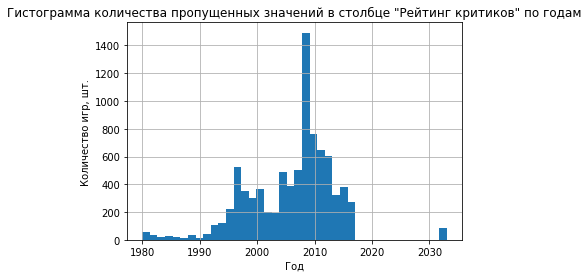

In [24]:
plt.title('Гистограмма количества пропущенных значений в столбце "Рейтинг критиков" по годам')
plt.xlabel('Год')
plt.ylabel('Количество игр, шт.')
df[df['critic_score'] == 0]['year_of_release'].hist(bins=40);

В 2008 и 2009 годах возможно был кризис у критиков. Очень много игр не было ими оценено. Было бы логичнее, если критики не ставили бы оценки до 2000 годов, но в в 2000-х годах игровая индустрия была достаточно развита. Это может быть сбой/ошибка данных.
Посмотрим, как распределены пропущенные значения в стобце "Рейтинг критиков" по платформам.

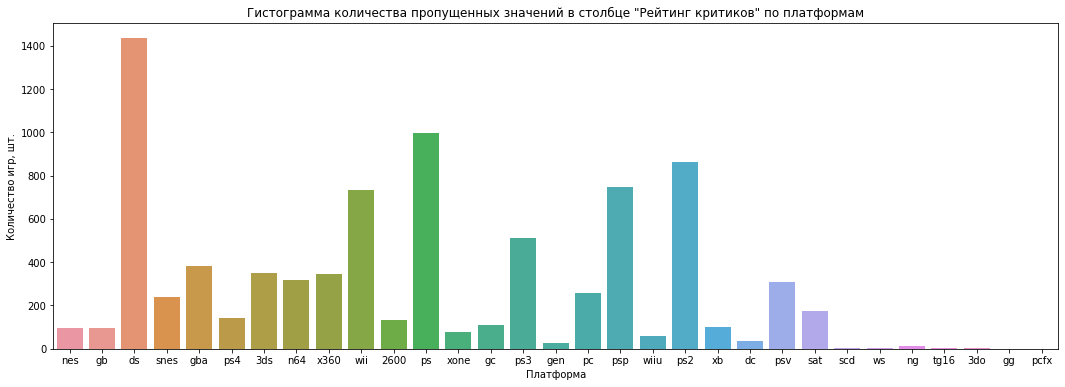

In [25]:
plt.figure(figsize=(18, 6))
sns.countplot(x='platform', data=df[(df['critic_score'] == 0)]);
plt.title('Гистограмма количества пропущенных значений в столбце "Рейтинг критиков" по платформам')
plt.xlabel('Платформа')
plt.ylabel('Количество игр, шт.')
plt.show()

Игры Nintendo DS и PS в большинстве были проигнорированы критиками. Но опять же это может быть сбой/ошибка данных. Следует пообщаться с аналитиком, готовившим эти данные.

Рассмотрим то же самое с рейтингом юзеров и возрастным рейтингом.

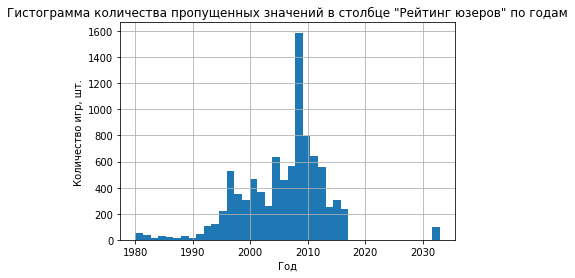

In [26]:
plt.title('Гистограмма количества пропущенных значений в столбце "Рейтинг юзеров" по годам')
plt.xlabel('Год')
plt.ylabel('Количество игр, шт.')
df[df['user_score'] == 0]['year_of_release'].hist(bins=40);

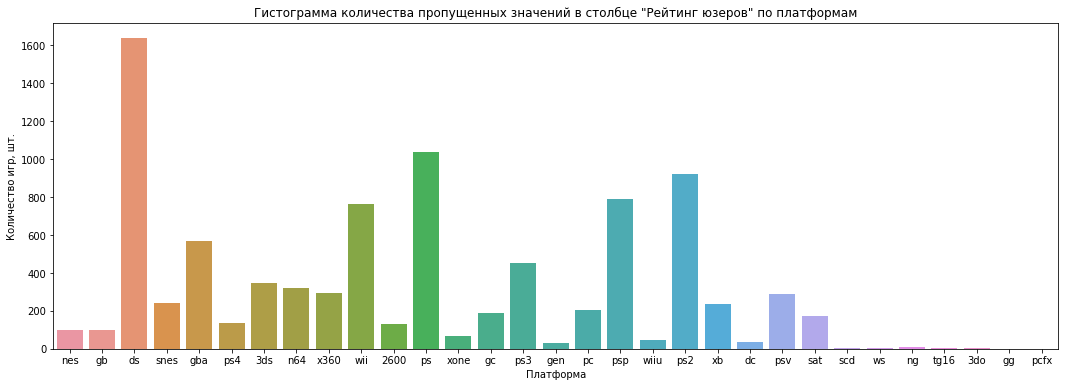

In [27]:
plt.figure(figsize=(18, 6))
sns.countplot(x='platform', data=df[(df['user_score'] == 0)]);
plt.title('Гистограмма количества пропущенных значений в столбце "Рейтинг юзеров" по платформам')
plt.xlabel('Платформа')
plt.ylabel('Количество игр, шт.')
plt.show()

Картина с рейтингом юзеров аналогична рейтингу критиков, только тут количество игр бОльшее.
Рассмотрим зависимость пропущенных значений в возрастном рейтинге от года выпуска и платформы.

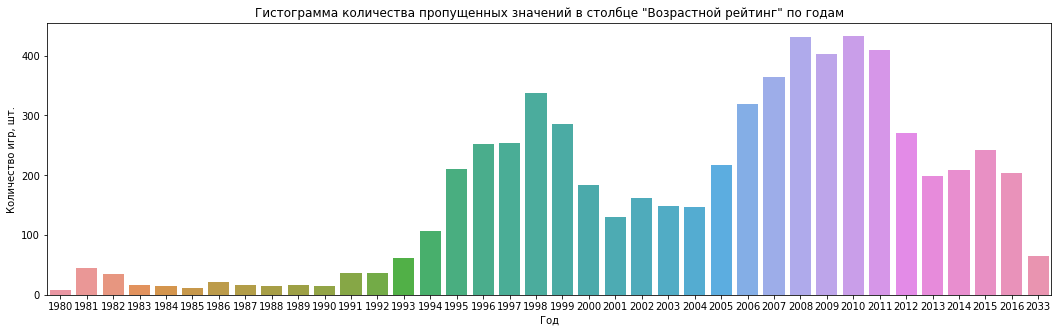

In [28]:
plt.figure(figsize=(18, 5))
sns.countplot(x='year_of_release', data=df[(df['rating'] == 'un')]);
plt.title('Гистограмма количества пропущенных значений в столбце "Возрастной рейтинг" по годам')
plt.xlabel('Год')
plt.ylabel('Количество игр, шт.')
plt.show()

С 1991 года рост количества игр без возрастного рейтинга, возможно просто игр стали больше выпускать и не успевали ставить рейтинги. Опять же есть вероятность, что это просто сбой в данных, так как пропущенных значений очень много.

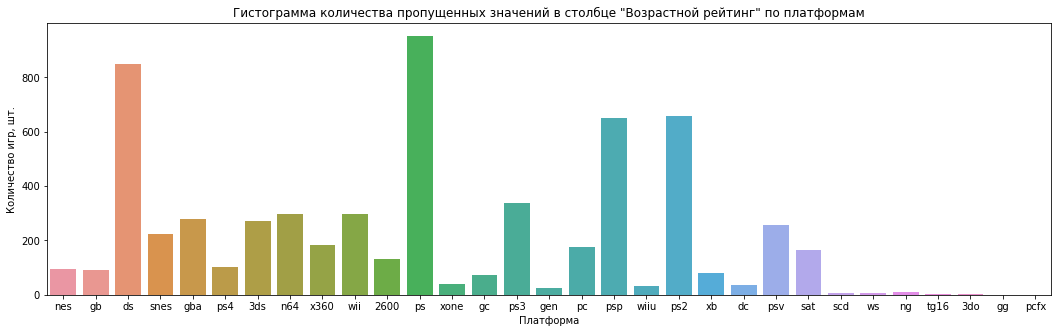

In [29]:
plt.figure(figsize=(18, 5))
sns.countplot(x='platform', data=df[(df['rating'] == 'un')]);
plt.title('Гистограмма количества пропущенных значений в столбце "Возрастной рейтинг" по платформам')
plt.xlabel('Платформа')
plt.ylabel('Количество игр, шт.')
plt.show()

На этот раз в лидеры по пропускам вышла PS, на 2м месте Nintendo DS. Nintendo DS исходя из всех графиков не очень популярная платформа по выставлению рейтингов.

Посчитаем суммарные продажи по всем играм.

In [30]:
df['total_sales'] = df['na_sales'] + df['eu_sales'] + df['jp_sales']
print('Суммарные продажи по региону Северная америка:', df['na_sales'].sum(), 'млн.шт.')
print('Суммарные продажи по региону Европа:', df['eu_sales'].sum(), 'млн.шт.')
print('Суммарные продажи по региону Япония:', df['jp_sales'].sum(), 'млн.шт.')
print('Итого: {:.2f}'.format(df['total_sales'].sum()), 'млн.шт.')

Суммарные продажи по региону Северная америка: 4402.35 млн.шт.
Суммарные продажи по региону Европа: 2424.67 млн.шт.
Суммарные продажи по региону Япония: 1297.37 млн.шт.
Итого: 8124.39 млн.шт.


## Исследовательский анализ данных <a name="3"></a>

Изучим как распределен выпуск игр по годам. Исключим 2033 год.

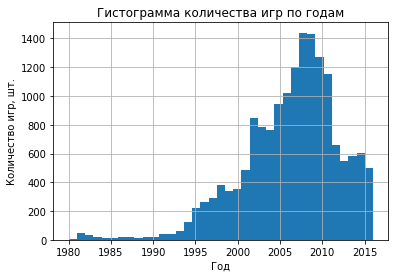

In [31]:
plt.title('Гистограмма количества игр по годам')
plt.xlabel('Год')
plt.ylabel('Количество игр, шт.')
df[df['year_of_release'] != 2033]['year_of_release'].hist(bins=37);
plt.show()

С 90-х наблюдается рост выпуска игр. Пик приходится на 2007-11 годы. Далее идет спад. Я думаю, это связано с ростом качества игр. Они становятся всё более детальными, улучшается графика, растут потребности игроманов в качественных играх. Некоторые игры разрабатываются годами. Но так же растёт количество игр выпускаемых для телефонов, виртуальной реальности, но у нас нет этих данных для проверки. Возможно для дальнейшего анализа стоило бы взять только игры 2013-16 годов выпуска. Они покажут наиболее точную тенденцию.

Посмотрим как менялись продажи по платформам. Какие платформы сделали больше всего продаж?

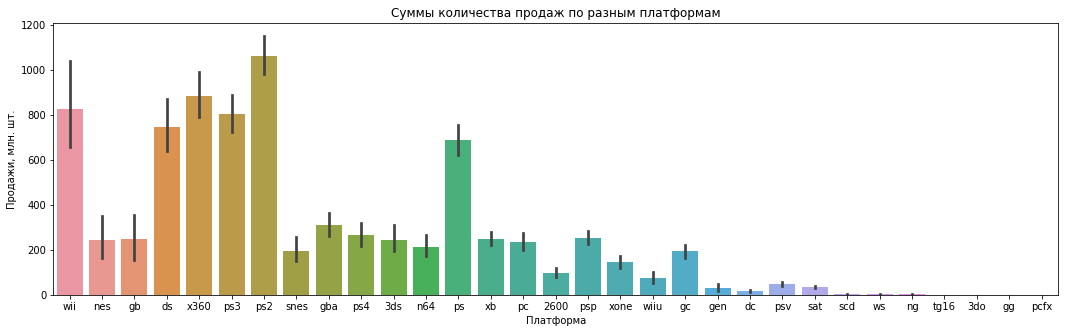

In [32]:
plt.figure(figsize=(18, 5))
sns.barplot(x='platform', y='total_sales', data=df, estimator=sum);
plt.title('Суммы количества продаж по разным платформам')
plt.xlabel('Платформа')
plt.ylabel('Продажи, млн. шт.')
plt.show()

Больше всего продаж у ps2, далее x360, wii, ps3, ds и ps. Остальные платформы отстают очень сильно.
Построим по самым популярным платформам график суммарных продаж по годам.

In [33]:
top_6_platforms_sales = df.pivot_table(index='platform', values='total_sales', aggfunc='sum')\
.sort_values(by='total_sales', ascending=False).head(6).copy()
top_6_platforms_sales

,total_sales
platform,
ps2,1062.33
x360,885.66
wii,828.44
ps3,803.97
ds,746.86
ps,689.95


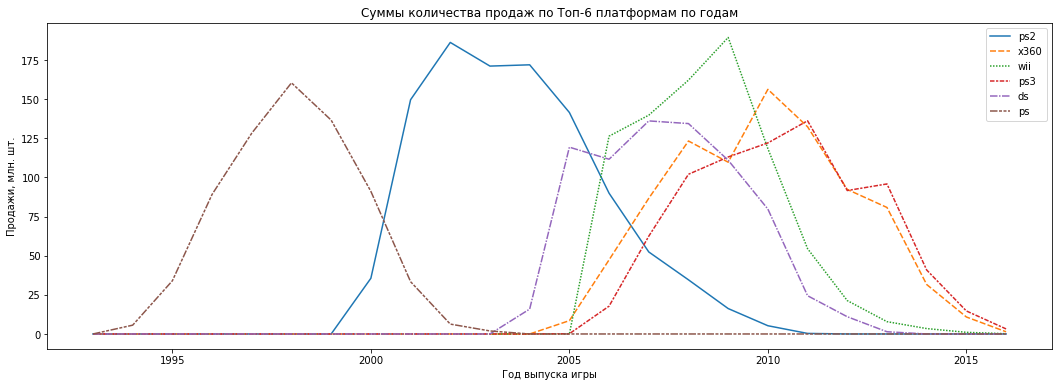

In [34]:
platform_years_sales = df.pivot_table(index='year_of_release', columns='platform', values='total_sales', aggfunc='sum')\
.fillna(0).query('year_of_release < 2017 & year_of_release > 1992')
plt.figure(figsize=(18, 6))
sns.lineplot(data=platform_years_sales[['ps2','x360','wii','ps3','ds','ps']]);
plt.title('Суммы количества продаж по Топ-6 платформам по годам')
plt.xlabel('Год выпуска игры')
plt.ylabel('Продажи, млн. шт.')
plt.show()

На графике виден рассвет продаж игр на самых популярных платформах. В 2005 году продажи PS упали до нуля. PS2 игрыперестали покупать в 2011. А у остальных продажи постепенно падают к 2016 году.

Найдем продолжительность жизни каждой платформы. То есть это разница между началом и концом продаж.

In [35]:
years_of_life_pl = df[df['year_of_release'] != 2033].pivot_table(index='platform', values='year_of_release', \
                                                                 aggfunc=('count', 'max', 'min'))
years_of_life_pl['years_of_life'] = years_of_life_pl['max'] - years_of_life_pl['min']
print('Продолжительность жизни разных платформ')
display(years_of_life_pl)
print('Разные игровые платформы существуют в среднем {:.2f} лет'.format(years_of_life_pl['years_of_life'].mean()))

Продолжительность жизни разных платформ


,count,max,min,years_of_life
platform,,,,
2600,117,2002,1980,22
3do,3,1995,1994,1
3ds,515,2016,2010,6
dc,52,2008,1998,10
ds,2129,2013,1985,28
gb,97,2001,1988,13
gba,813,2007,2000,7
gc,552,2007,2001,6
gen,29,1994,1990,4


Разные игровые платформы существуют в среднем 8.16 лет


Как я уже писал выше, возьмем для анализа данные за 2012-2016 годы, так как они наиболее близки к нашему времени. Старые платформы уже исчезли, а новые теряют продажи.

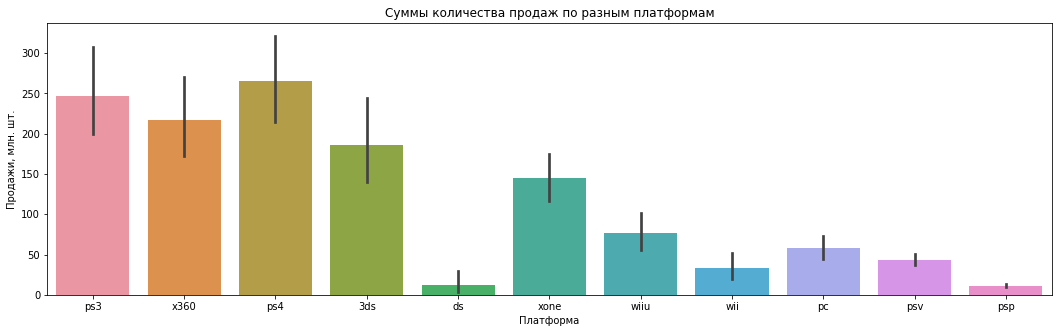

In [36]:
df_good = df.query('year_of_release > 2011 & year_of_release < 2017')
plt.figure(figsize=(18, 5))
sns.barplot(x='platform', y='total_sales', data=df_good, estimator=sum);
plt.title('Суммы количества продаж по разным платформам')
plt.xlabel('Платформа')
plt.ylabel('Продажи, млн. шт.')
plt.show()

Самые популярные платформы по продажам в 2012-16 годах - ps4, ps3, x360, 3ds, xone.

Рассмотрим продажи по всем платформам за 2012-2016 годы.

In [37]:
df_good.pivot_table(index='year_of_release', columns='platform', values='total_sales', aggfunc='sum')\
             .fillna(0)

platform,3ds,ds,pc,ps3,ps4,psp,psv,wii,wiiu,x360,xone
year_of_release,,,,,,,,,,,
2012,49.14,11.01,20.61,91.64,0.00,7.76,13.65,21.33,16.30,92.34,0.00
2013,53.97,1.42,11.52,95.85,22.12,3.34,9.14,7.87,20.12,80.82,17.21
2014,41.75,0.00,12.69,40.88,84.22,0.24,10.56,3.45,20.35,31.61,49.26
2015,26.75,0.00,7.93,14.70,100.44,0.12,5.93,1.05,15.22,10.86,54.67
2016,14.50,0.00,4.89,3.23,59.01,0.00,4.10,0.17,4.25,1.40,23.91


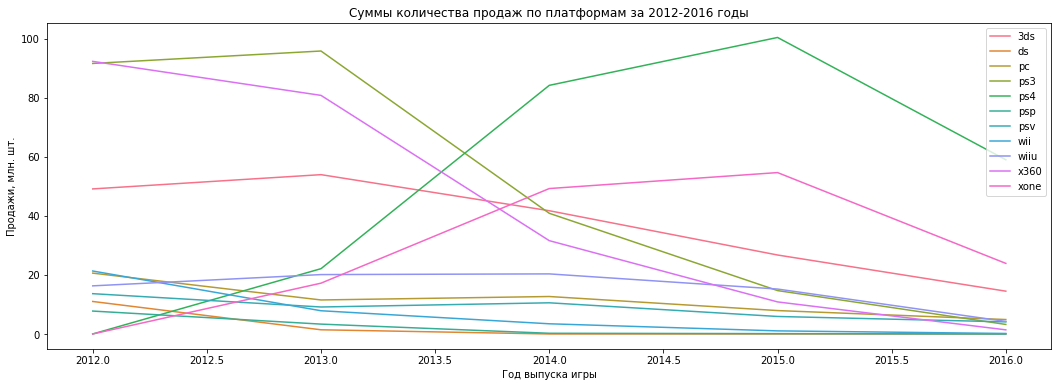

In [38]:
plt.figure(figsize=(18, 6))
sns.lineplot(data=df_good.pivot_table(index='year_of_release', columns='platform', values='total_sales', aggfunc='sum')\
             .fillna(0), dashes=False);
plt.title('Суммы количества продаж по платформам за 2012-2016 годы')
plt.xlabel('Год выпуска игры')
plt.ylabel('Продажи, млн. шт.')
plt.show()

Люди перестают покупать игры. Топ-3 продаж на 2016 год - явный лидер ps4, далее xone и 3ds. На 2016 год они самые прибыльные.
Игры остальных платформ находятся далеко внизу.

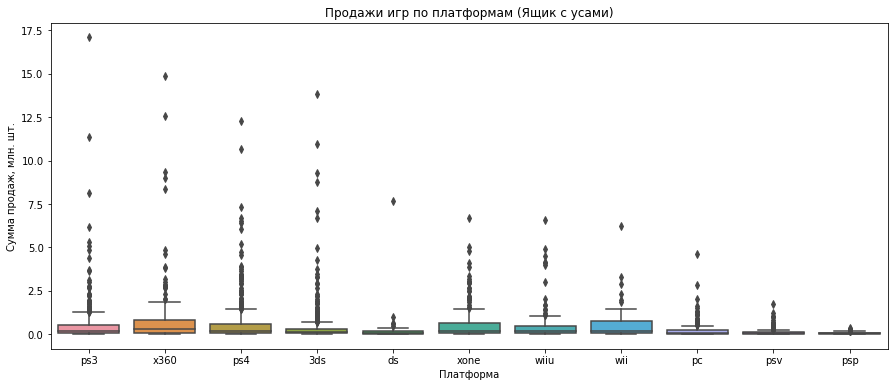

In [39]:
plt.figure(figsize=(15, 6))
sns.boxplot(x="platform", y="total_sales", data=df_good);
plt.title('Продажи игр по платформам (Ящик с усами)')
plt.xlabel('Платформа')
plt.ylabel('Сумма продаж, млн. шт.')
plt.show()

Очень много слишком больших значений. Это самые продаваемые игры. Ограничим график по оси "у" для более детального просмотра. Самые популярные/продаваемые игры на ps3, x360, 3ds, ps4.

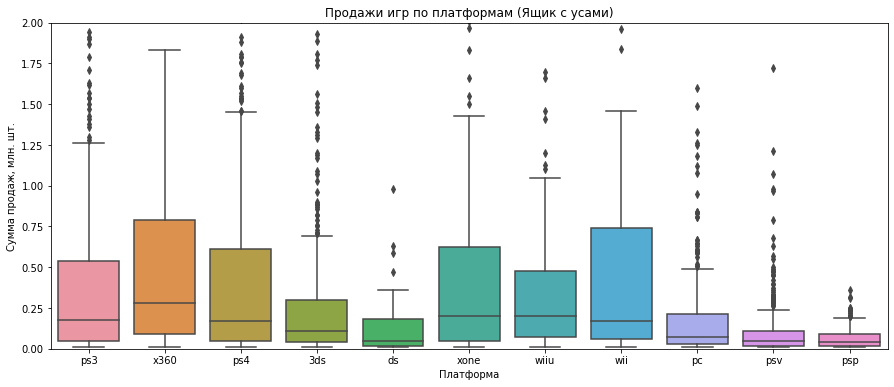

,count,sum,mean,median,std,min,max
,total_sales,total_sales,total_sales,total_sales,total_sales,total_sales,total_sales
platform,,,,,,,
3ds,397,186.11,0.468791,0.110,1.310852,0.01,13.82
ds,32,12.43,0.388437,0.045,1.344374,0.01,7.65
pc,255,57.64,0.226039,0.070,0.440031,0.01,4.60
ps3,494,246.30,0.498583,0.175,1.200135,0.01,17.09
ps4,392,265.79,0.678036,0.170,1.355221,0.01,12.25
psp,175,11.46,0.065486,0.040,0.070341,0.01,0.36
psv,411,43.38,0.105547,0.050,0.169875,0.01,1.72
wii,55,33.87,0.615818,0.170,1.062191,0.01,6.21


In [40]:
plt.figure(figsize=(15, 6))
sns.boxplot(x="platform", y="total_sales", data=df_good);
plt.title('Продажи игр по платформам (Ящик с усами)')
plt.xlabel('Платформа')
plt.ylabel('Сумма продаж, млн. шт.')
plt.ylim((0,2))
plt.show()
df_good.pivot_table(index='platform', values='total_sales', aggfunc=['count', 'sum', 'mean', 'median', 'std', 'min', 'max'])

Больше всего продаж у ps4, ps3, x360, 3ds, xone. Медианное значение выше у x360, xone, wiiu. То есть у них бОльшее количество игр продавалось в бОльшем количестве. У них больше всего популярных игр.

Рассмотрим влияние отзывы пользователей и критиков на продажи. Возьмём самые популярные: ps4, xone, 3ds, ps3 и x360.

Зависимость продаж от рейтингов критиков и юзеров по платформе ps4


,total_sales,critic_score,user_score
total_sales,1.000000,0.226999,0.112635
critic_score,0.226999,1.000000,0.900850
user_score,0.112635,0.900850,1.000000


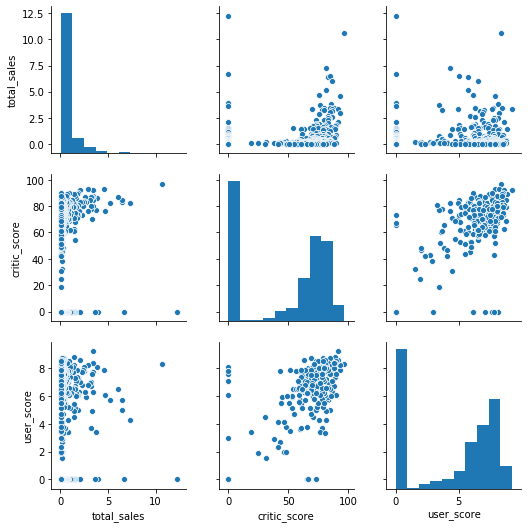

Зависимость продаж от рейтингов критиков и юзеров по платформе xone


,total_sales,critic_score,user_score
total_sales,1.000000,0.275176,0.116781
critic_score,0.275176,1.000000,0.774153
user_score,0.116781,0.774153,1.000000


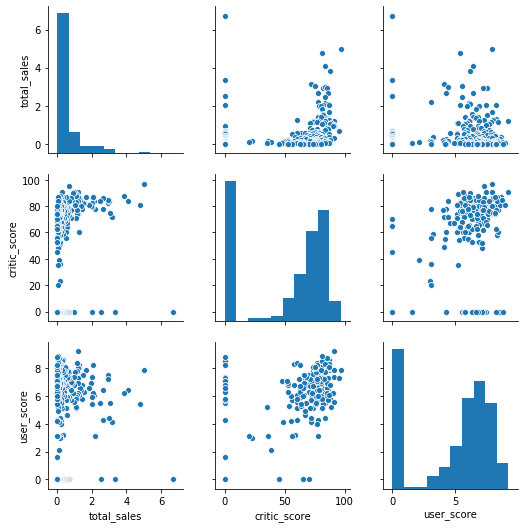

Зависимость продаж от рейтингов критиков и юзеров по платформе 3ds


,total_sales,critic_score,user_score
total_sales,1.000000,0.147050,0.127081
critic_score,0.147050,1.000000,0.911341
user_score,0.127081,0.911341,1.000000


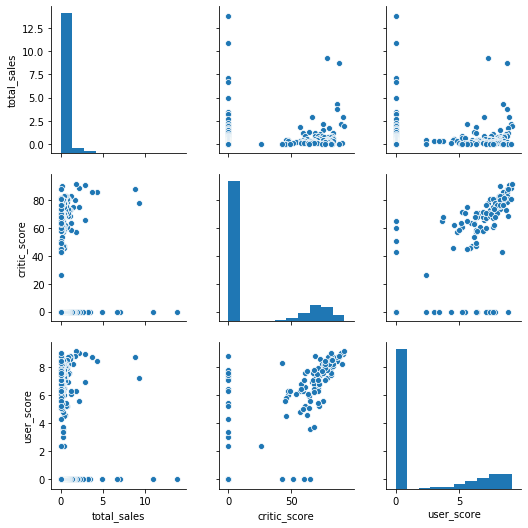

Зависимость продаж от рейтингов критиков и юзеров по платформе ps3


,total_sales,critic_score,user_score
total_sales,1.000000,0.303569,0.217873
critic_score,0.303569,1.000000,0.761169
user_score,0.217873,0.761169,1.000000


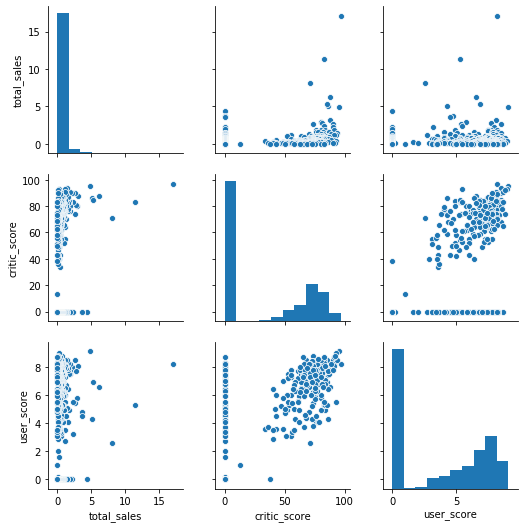

Зависимость продаж от рейтингов критиков и юзеров по платформе x360


,total_sales,critic_score,user_score
total_sales,1.00000,0.263600,0.102410
critic_score,0.26360,1.000000,0.644494
user_score,0.10241,0.644494,1.000000


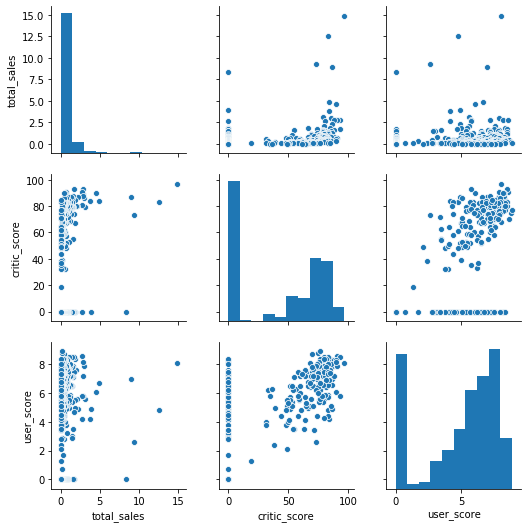

In [41]:
for i in ['ps4', 'xone', '3ds', 'ps3', 'x360']:
    print('Зависимость продаж от рейтингов критиков и юзеров по платформе', i)
    df_good_platform = df_good[df_good['platform'] == i]
    display(df_good_platform[['total_sales', 'critic_score', 'user_score']].corr())
    sns.pairplot(df_good_platform[['total_sales', 'critic_score', 'user_score']])
    plt.show()

Общие продажи по платформе ps4 зависят от рейтинга критиков только на 23%, еще меньше от рейтинга юзеров - 11%. 
По другим платформам: xone - 27,5% и 12% соответственно, 3ds - 15% и 13%, ps3 - 30% и 22%, x360 - 26% и 10%.
То есть рейтинг критиков больше влияет на количество продаж, кроме 3ds, где зависимость почти равная.
Посмотрим, что будет, если удалить нулевые значения.

Зависимость продаж от рейтингов критиков и юзеров по платформе ps4


,total_sales,critic_score,user_score
total_sales,1.000000,0.405223,-0.032923
critic_score,0.405223,1.000000,0.557654
user_score,-0.032923,0.557654,1.000000


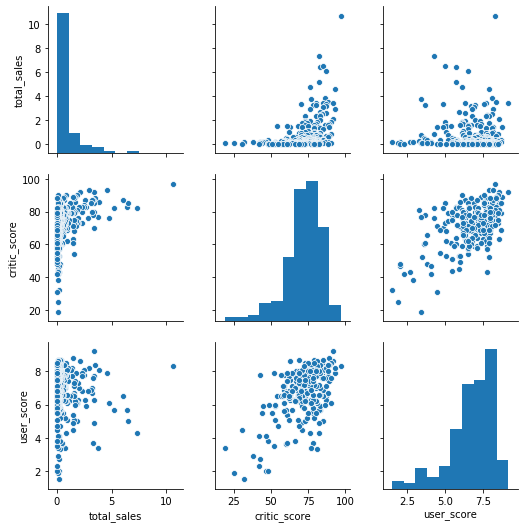

Зависимость продаж от рейтингов критиков и юзеров по платформе xone


,total_sales,critic_score,user_score
total_sales,1.000000,0.410657,-0.093737
critic_score,0.410657,1.000000,0.472462
user_score,-0.093737,0.472462,1.000000


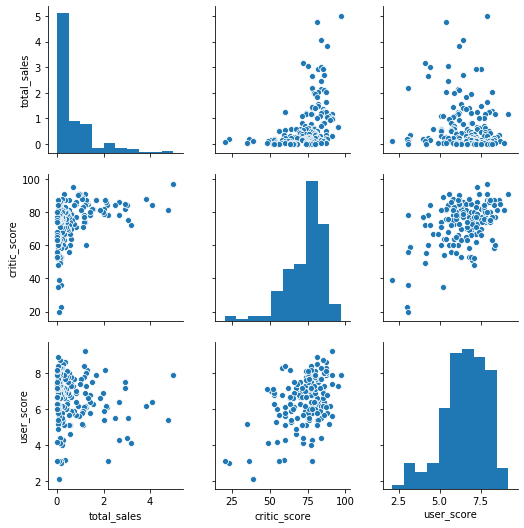

Зависимость продаж от рейтингов критиков и юзеров по платформе 3ds


,total_sales,critic_score,user_score
total_sales,1.000000,0.310373,0.204248
critic_score,0.310373,1.000000,0.721517
user_score,0.204248,0.721517,1.000000


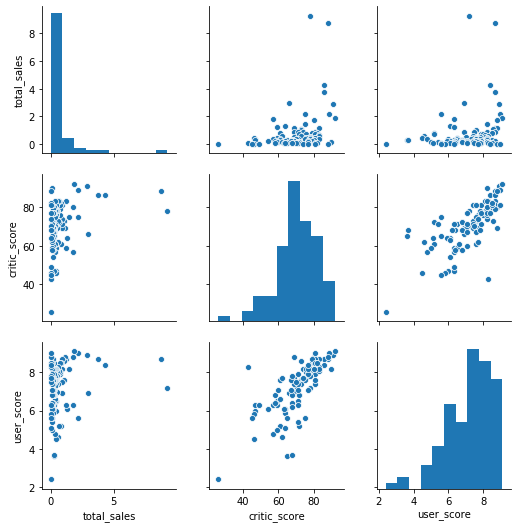

Зависимость продаж от рейтингов критиков и юзеров по платформе ps3


,total_sales,critic_score,user_score
total_sales,1.000000,0.333750,0.001941
critic_score,0.333750,1.000000,0.539525
user_score,0.001941,0.539525,1.000000


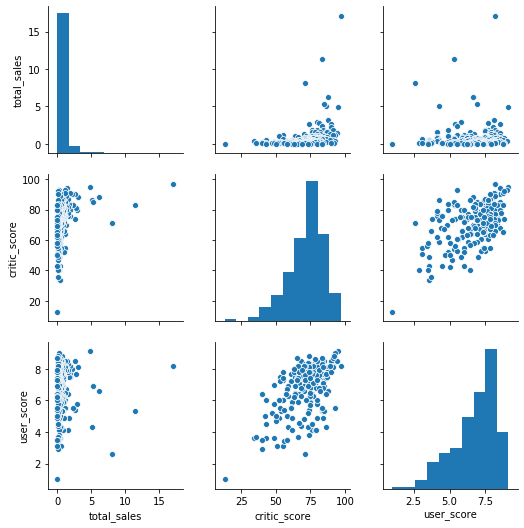

Зависимость продаж от рейтингов критиков и юзеров по платформе x360


,total_sales,critic_score,user_score
total_sales,1.000000,0.359942,-0.002220
critic_score,0.359942,1.000000,0.557952
user_score,-0.002220,0.557952,1.000000


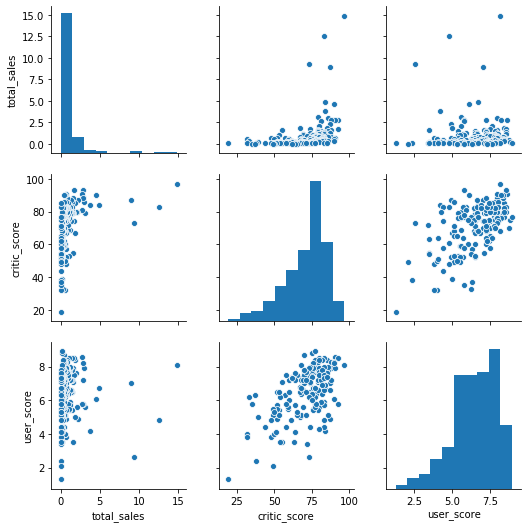

In [42]:
for i in ['ps4', 'xone', '3ds', 'ps3', 'x360']:
    print('Зависимость продаж от рейтингов критиков и юзеров по платформе', i)
    df_good_platform = df_good[df_good['platform'] == i]
    display(df_good_platform.query('critic_score > 0 & user_score > 0')[['total_sales', 'critic_score', 'user_score']].corr())
    sns.pairplot(df_good_platform.query('critic_score > 0 & user_score > 0')[['total_sales', 'critic_score', 'user_score']])
    plt.show()

После удаления нулевых значений влияние рейтинга критиков на продажи игр ps4 значительно выросло до 40,5%. А по рейтингу юзеров образовалась обратная связь, но всего лишь 3%(по xone - 9%). Та же картина и по остальным платформам: лишь по ps3 влияние критиков выросло незначительно. А по 3ds зависимость рейтинга юзеров на продажи снизилась, но не до нуля, а до 20%. То есть рейтинг критиков оказывает бОльшее влияние на продажи по всем платформам. А рейтинг юзеров слабо влияет на продажи. Покупатели больше доверяют критикам.

Посмотрим как обстоят дела по остальным платформам

In [43]:
for i in df_good[~df_good['platform'].isin(['ps4', 'xone', '3ds', 'ps3', 'x360'])]['platform'].unique():
    print('Зависимость продаж от рейтингов критиков и юзеров по платформе', i)
    df_good_platform = df_good[df_good['platform'] == i]
    display(df_good_platform.query('critic_score > 0 & user_score > 0')[['total_sales', 'critic_score', 'user_score']].corr())

Зависимость продаж от рейтингов критиков и юзеров по платформе ds


,total_sales,critic_score,user_score
total_sales,NaN,NaN,NaN
critic_score,NaN,NaN,NaN
user_score,NaN,NaN,NaN


Зависимость продаж от рейтингов критиков и юзеров по платформе wiiu


,total_sales,critic_score,user_score
total_sales,1.000000,0.34958,0.391084
critic_score,0.349580,1.00000,0.770080
user_score,0.391084,0.77008,1.000000


Зависимость продаж от рейтингов критиков и юзеров по платформе wii


,total_sales,critic_score,user_score
total_sales,1.000000,-0.403877,-0.052267
critic_score,-0.403877,1.000000,0.780222
user_score,-0.052267,0.780222,1.000000


Зависимость продаж от рейтингов критиков и юзеров по платформе pc


,total_sales,critic_score,user_score
total_sales,1.000000,0.239648,-0.136800
critic_score,0.239648,1.000000,0.431879
user_score,-0.136800,0.431879,1.000000


Зависимость продаж от рейтингов критиков и юзеров по платформе psv


,total_sales,critic_score,user_score
total_sales,1.000000,0.103226,0.027681
critic_score,0.103226,1.000000,0.699199
user_score,0.027681,0.699199,1.000000


Зависимость продаж от рейтингов критиков и юзеров по платформе psp


,total_sales,critic_score,user_score
total_sales,NaN,NaN,NaN
critic_score,NaN,NaN,NaN
user_score,NaN,NaN,NaN


По другим платформам ситуация немного другая. По ds, wiiu и psv зависимость рейтинга критиков и юзеров почти одинаковая. По wii и psp рейтинг юзеров сильнее влияет на продажи. А по PC наоборот, рейтинг критиков намного сильнее влияет на рейтинг юзеров: 20% против 4%.

Рассмотрим продажи по жанрам.

,genre,count,sum,sum/count
0,action,1041,394.65,0.379107
1,shooter,237,267.49,1.128650
2,role-playing,370,177.97,0.481000
3,sports,268,158.63,0.591903
4,misc,193,77.61,0.402124
5,platform,85,55.42,0.652000
6,racing,115,47.01,0.408783
7,fighting,109,40.02,0.367156
8,simulation,80,32.93,0.411625
9,adventure,302,26.62,0.088146


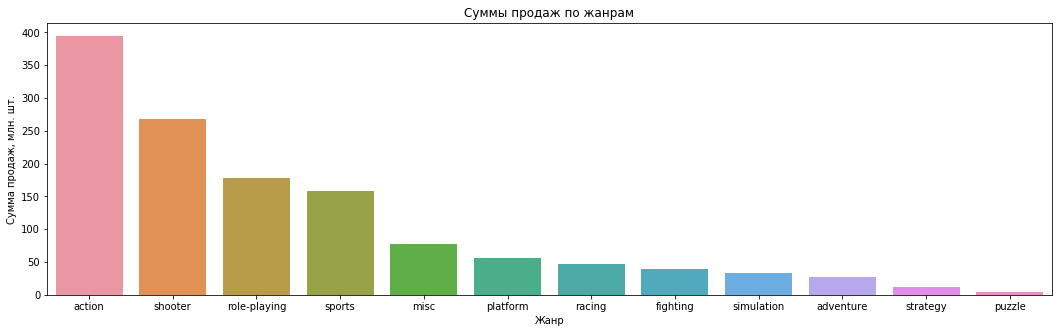

In [56]:
df_good_genre = df_good.pivot_table(index='genre', values='total_sales', aggfunc=('count', 'sum'))\
.sort_values(by='sum', ascending=False)
df_good_genre['sum/count'] = df_good_genre['sum'] / df_good_genre['count']
df_good_genre = df_good_genre.reset_index()
display(df_good_genre)
plt.figure(figsize=(18, 5))
sns.barplot(x='genre', y='sum', data=df_good_genre, estimator=sum);
plt.title('Суммы продаж по жанрам')
plt.xlabel('Жанр')
plt.ylabel('Сумма продаж, млн. шт.')
plt.show()

Больше всего продаж приходится на жанры экшн, шутер, ролевые игры и спорт. Но по количеству строк с большим отрывом лидирует жанр экшн. И получается средняя сумма количества продаж на одну строку приходится 0,38 млн.шт., в то время как на шутер - 1,1 млн.штук.
Самые низкие продажи у паззлов, стратегий, приключений и симуляторов.

## Составим портрет пользователей по регионам. <a name="4"></a>

Какие самые популярные платформы в разных регионах по количеству продаж? Сравним за весь период и за 2012-16 годы.

------- na_sales -------


,platform,all_years,2012-2016
0,x360,602.47,140.57
1,ps4,108.74,108.74
2,ps3,393.49,103.74
3,xone,93.12,93.12
4,3ds,83.49,55.49
5,wiiu,38.10,38.10
6,pc,94.53,19.26
7,wii,496.90,18.14
8,psv,12.58,10.98
9,ds,382.40,4.93


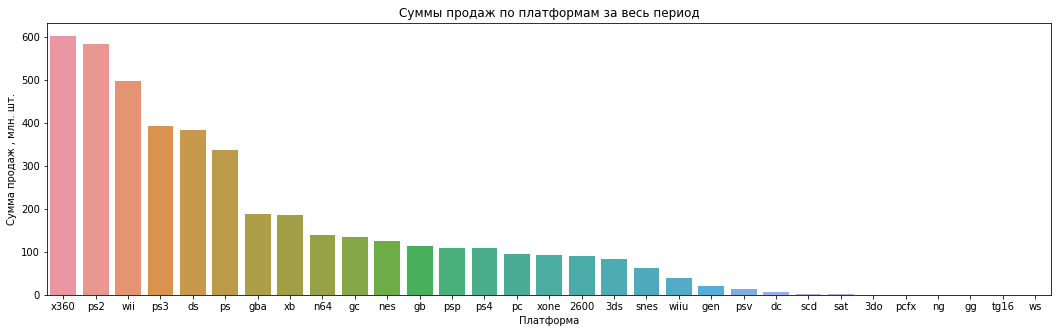

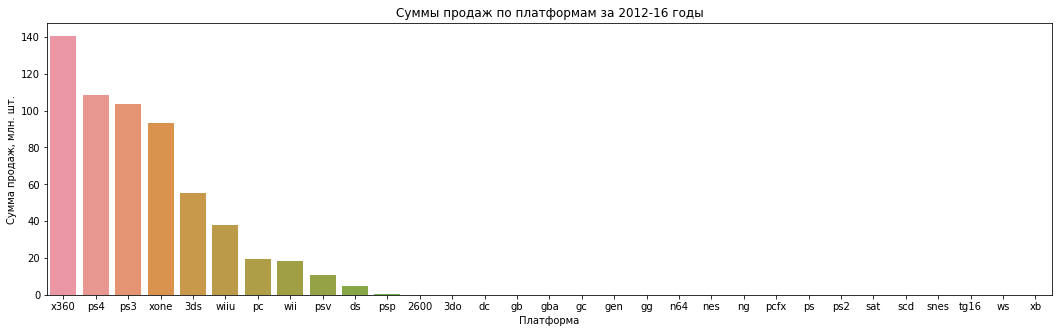

------- eu_sales -------


,platform,all_years,2012-2016
0,ps4,141.09,141.09
1,ps3,330.29,107.27
2,x360,270.76,74.89
3,xone,51.59,51.59
4,3ds,61.48,42.83
5,pc,142.44,38.38
6,wiiu,25.13,25.13
7,wii,262.21,12.34
8,psv,13.12,11.36
9,ds,188.89,3.78


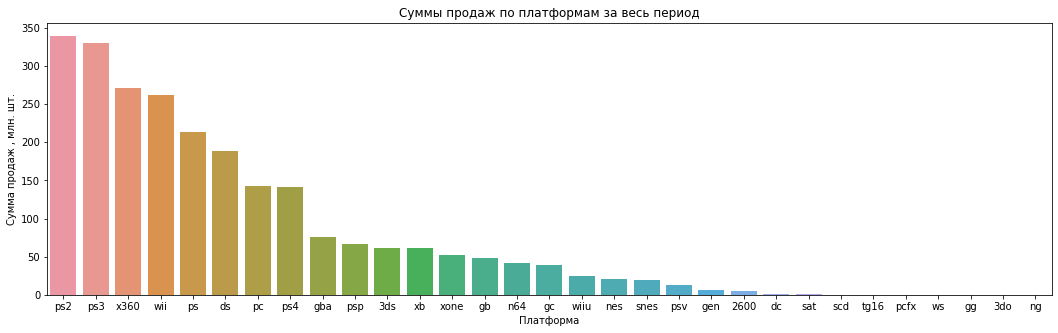

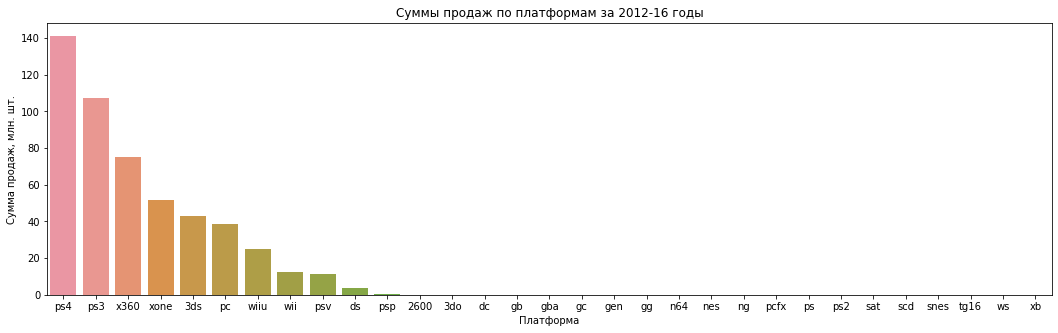

------- jp_sales -------


,platform,all_years,2012-2016
0,3ds,100.67,87.79
1,ps3,80.19,35.29
2,psv,21.91,21.04
3,ps4,15.96,15.96
4,wiiu,13.01,13.01
5,psp,76.78,10.71
6,ds,175.57,3.72
7,wii,69.33,3.39
8,x360,12.43,1.57
9,xone,0.34,0.34


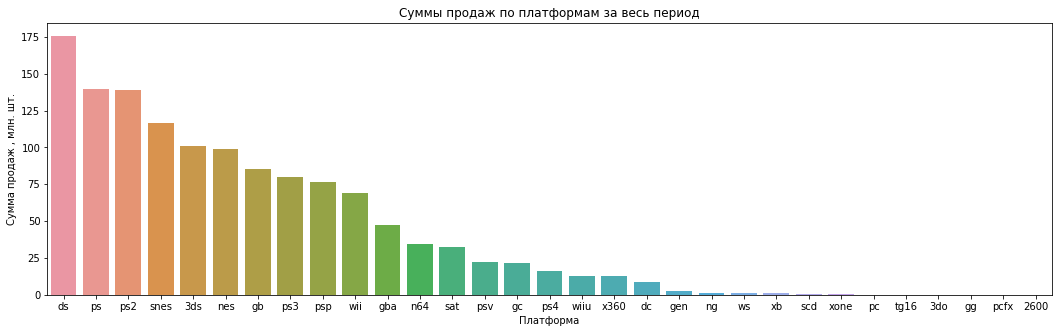

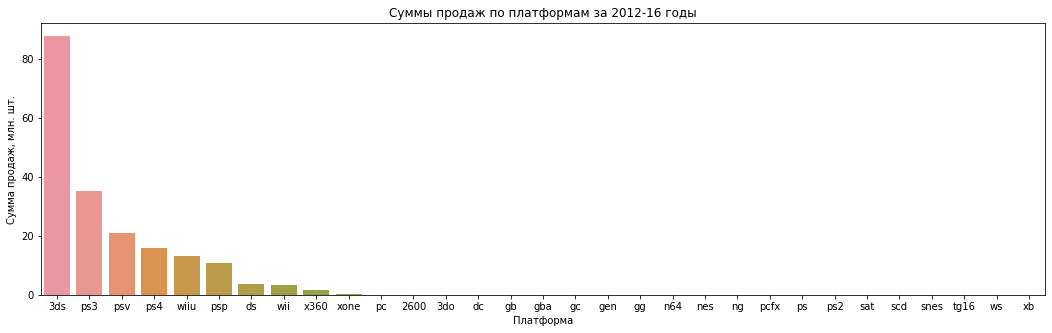

In [45]:
for i in ['na_sales', 'eu_sales', 'jp_sales']:
    platform_region_sales_all = df.pivot_table(index='platform', values=i, aggfunc='sum')
    platform_region_sales_12_16 = df_good.pivot_table(index='platform', values=i, aggfunc='sum')
    platform_region_sales = platform_region_sales_all.merge(platform_region_sales_12_16, on='platform', how='outer')
    platform_region_sales.columns = ['all_years', '2012-2016']
    print('-------', i, '-------')
    display(platform_region_sales.sort_values(by='2012-2016', ascending=False).reset_index())
    plt.figure(figsize=(18, 5))
    sns.barplot(x='platform', y='all_years', data=platform_region_sales.sort_values(by='all_years', ascending=False)\
                .reset_index());
    plt.title('Суммы продаж по платформам за весь период')
    plt.xlabel('Платформа')
    plt.ylabel('Сумма продаж , млн. шт.')
    plt.show()
    plt.figure(figsize=(18, 5))
    sns.barplot(x='platform', y='2012-2016', data=platform_region_sales.sort_values(by='2012-2016', ascending=False)\
                .reset_index());
    plt.title('Суммы продаж по платформам за 2012-16 годы')
    plt.xlabel('Платформа')
    plt.ylabel('Сумма продаж, млн. шт.')
    plt.show()

За весь период самой популярной по продажам платформой в Северной Америке является x360 (602 млн.шт.), немного её уступает ps2 (584 млн.шт.) и замыкает тройку wii (497 млн.шт.). В наше время x360 значительно снизила продажи, более чем в 4 раза, но всё равно осталась на 1-м месте. А вот для ps2 к 2012 году перестали выпускать игры, её продажи составили 0. Но её заменили платформы нового поколения, ps4 и ps3, которые уверенно держат 2-е и 3-е места соответственно. А вот продажи игр wii снизились более чем в 27 раз. Так же в 2012-16 годах уверенное 4-е место занимает xone, немного отстав от ps. И наконец в столбце 2012-16, там где NaN, можно посмотреть на платформы, игры для которых уже не продают официально, но наверняка есть любители, которые до сих пор в них играют.

Что же касается Европы, то x360 здесь значительно уступает свои позиции ps2 и ps3 с продажами 339 млн.шт. и 330 млн.шт. соответственно. x360 занимает тут лишь 3-е место за весь период набрав 271 млн.шт. продаж. В период 2012-16: x360 сохраняет 3-е место, но со снижением продаж в 3,6 раз. 1-е и 2-е места занимают ps4 и ps3.

В Японии за всё время самой популярной платформой была Nintendo DS, 2-е и 3-е места делят ps и ps2 с почти одинаковым количеством продаж. В 2012-16 годах Nintendo уверенно держит лидерство, но уже другая её версия Nintendo 3DS. На 2-м и 3-м местах ps3 и PS Vita.

Далее посмотрим, что с жанрами.

------- na_sales -------


,all_years,2012-2016
genre,,
action,879.01,180.15
shooter,592.24,144.79
sports,684.43,81.53
role-playing,330.81,64.00
misc,407.27,38.19
platform,445.50,25.38
fighting,223.36,19.79
racing,359.35,17.22
adventure,105.26,8.92


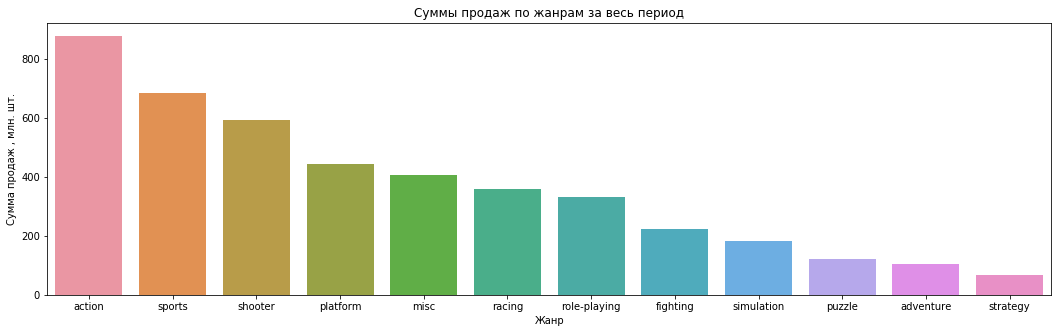

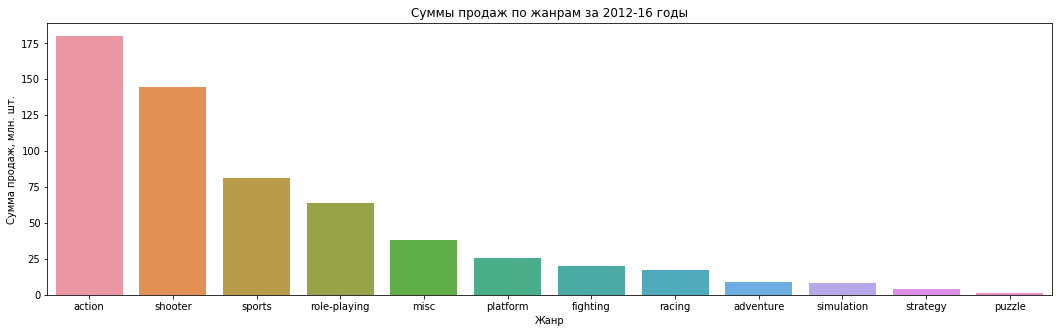

------- eu_sales -------


,all_years,2012-2016
genre,,
action,519.13,161.70
shooter,317.34,113.47
sports,376.79,69.09
role-playing,188.71,48.53
racing,236.51,27.29
misc,212.74,26.32
platform,200.35,21.41
simulation,113.52,14.55
fighting,100.33,10.79


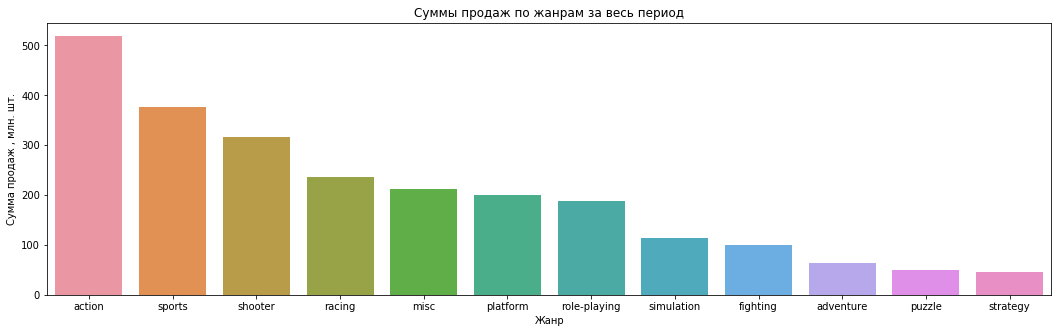

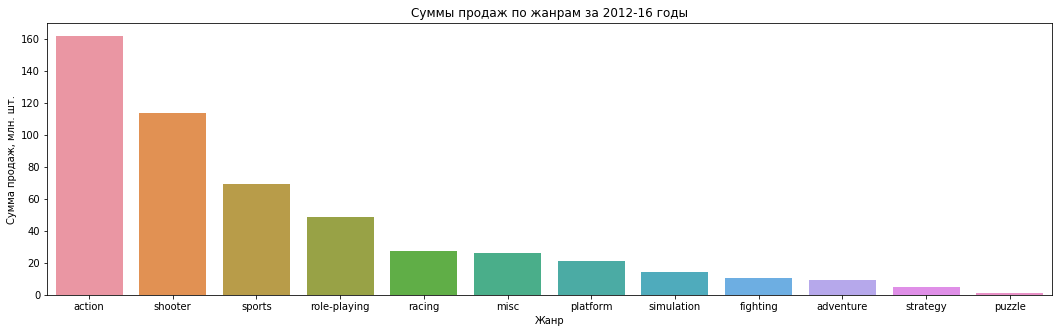

------- jp_sales -------


,all_years,2012-2016
genre,,
role-playing,355.41,65.44
action,161.43,52.80
misc,108.11,13.10
simulation,63.80,10.41
fighting,87.48,9.44
shooter,38.76,9.23
platform,130.83,8.63
adventure,52.30,8.24
sports,135.54,8.01


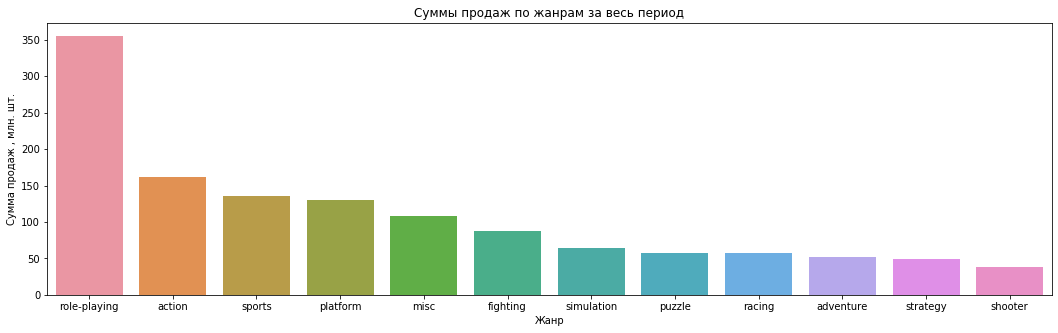

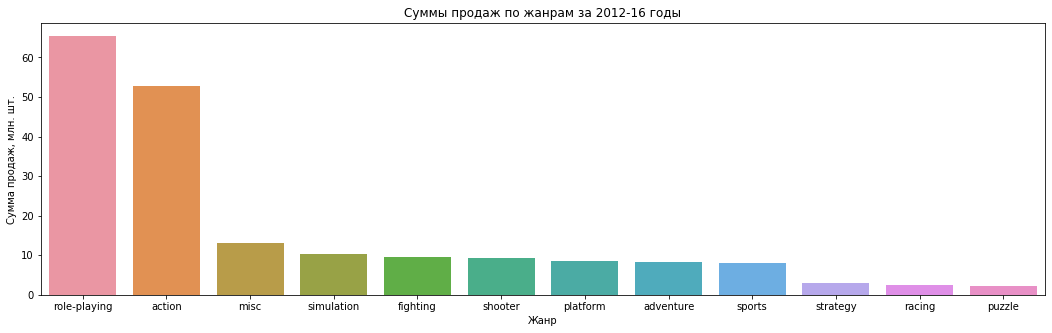

In [46]:
for i in ['na_sales', 'eu_sales', 'jp_sales']:
    platform_region_sales_all = df.pivot_table(index='genre', values=i, aggfunc='sum')
    platform_region_sales_12_16 = df_good.pivot_table(index='genre', values=i, aggfunc='sum')
    platform_region_sales = platform_region_sales_all.merge(platform_region_sales_12_16, on='genre', how='outer')
    platform_region_sales.columns = ['all_years', '2012-2016']
    print('-------', i, '-------')
    display(platform_region_sales.sort_values(by='2012-2016', ascending=False))
    plt.figure(figsize=(18, 5))
    sns.barplot(x='genre', y='all_years', data=platform_region_sales.sort_values(by='all_years', ascending=False)\
                .reset_index());
    plt.title('Суммы продаж по жанрам за весь период')
    plt.xlabel('Жанр')
    plt.ylabel('Сумма продаж , млн. шт.')
    plt.show()
    plt.figure(figsize=(18, 5))
    sns.barplot(x='genre', y='2012-2016', data=platform_region_sales.sort_values(by='2012-2016', ascending=False)\
                .reset_index());
    plt.title('Суммы продаж по жанрам за 2012-16 годы')
    plt.xlabel('Жанр')
    plt.ylabel('Сумма продаж, млн. шт.')
    plt.show()

По жанрам в Северной Америке и Европе лидер - экшн. А в Японии - ролевые игры. Ох уж эта Япония :) Совершенно другая культура, отличная от европейской и американской, поэтому такой и результат.

Влияет ли рейтинг ESRB на продажи в отдельном регионе?

------- na_sales -------


,all_years,2012-2016
rating,,
m,768.59,242.34
e,1342.70,117.74
un,1134.18,83.30
e10+,365.40,80.12
t,785.59,69.80
ao,1.26,NaN
ec,2.04,NaN
k-a,2.59,NaN
rp,0.00,NaN


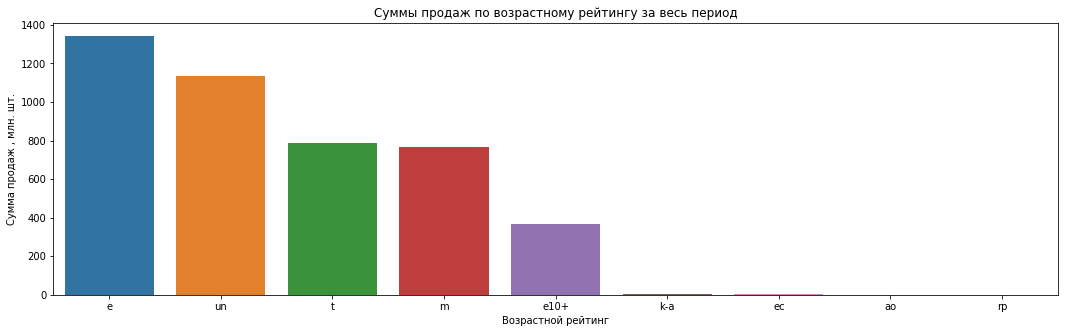

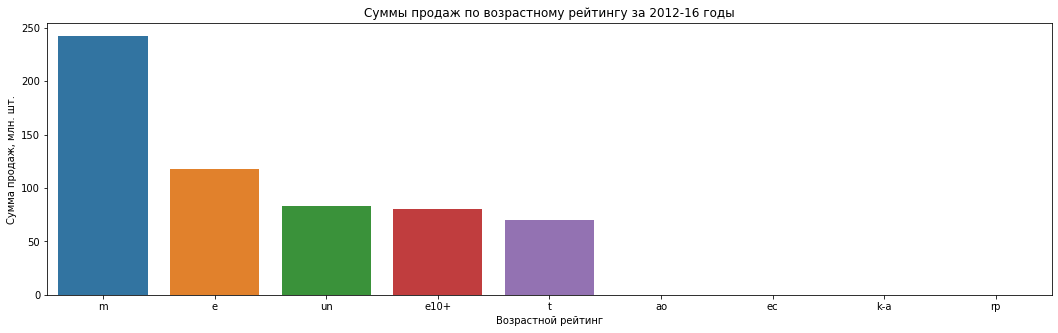

------- eu_sales -------


,all_years,2012-2016
rating,,
m,501.98,206.43
e,733.40,115.35
un,547.77,70.51
e10+,195.56,59.85
t,444.73,57.04
ao,0.61,NaN
ec,0.11,NaN
k-a,0.29,NaN
rp,0.22,NaN


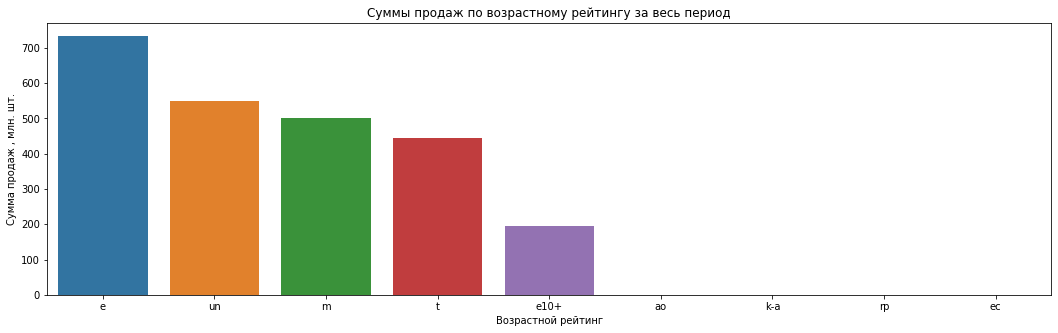

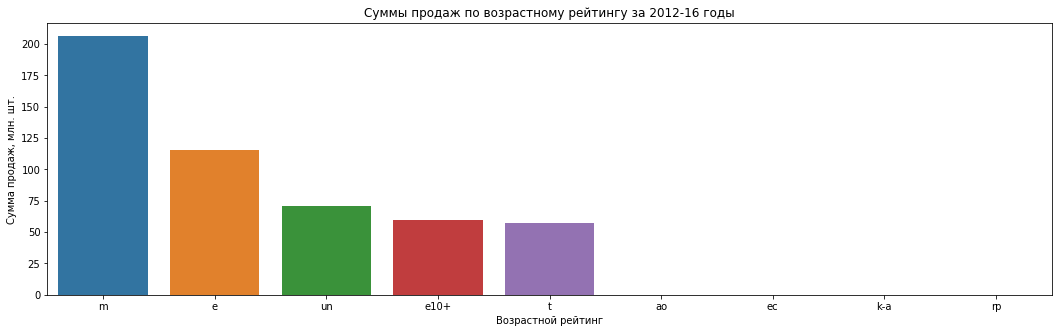

------- jp_sales -------


,all_years,2012-2016
rating,,
un,803.99,103.26
e,211.07,29.27
t,164.15,29.13
m,68.42,22.59
e10+,48.24,8.57
ao,0.00,NaN
ec,0.00,NaN
k-a,1.49,NaN
rp,0.01,NaN


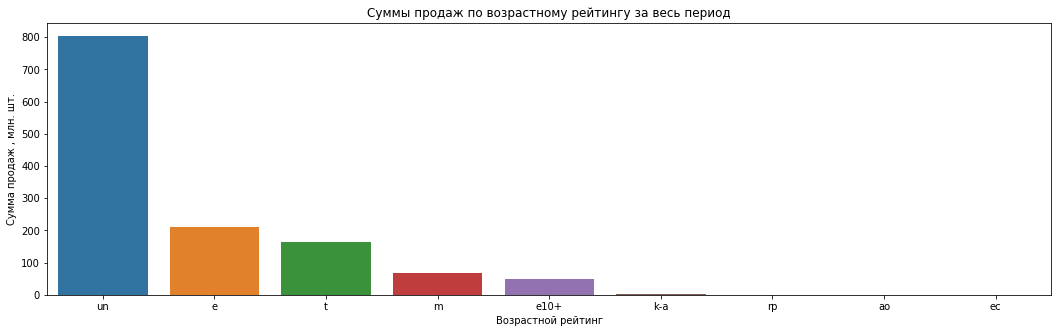

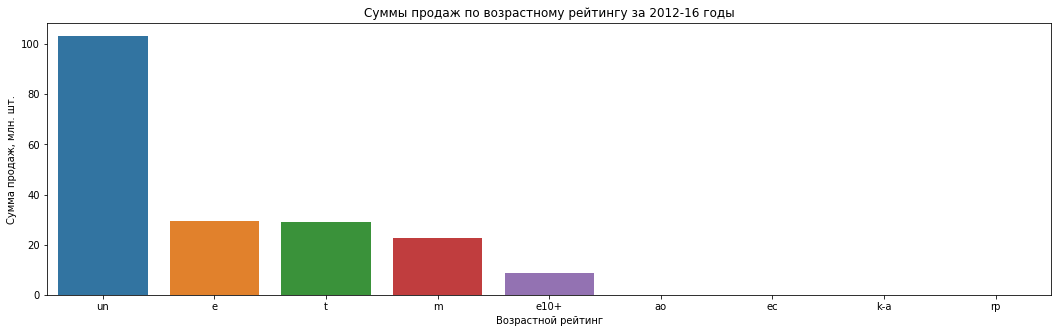

In [47]:
for i in ['na_sales', 'eu_sales', 'jp_sales']:
    platform_region_sales_all = df.pivot_table(index='rating', values=i, aggfunc='sum')
    platform_region_sales_12_16 = df_good.pivot_table(index='rating', values=i, aggfunc='sum')
    platform_region_sales = platform_region_sales_all.merge(platform_region_sales_12_16, on='rating', how='outer')
    platform_region_sales.columns = ['all_years', '2012-2016']
    print('-------', i, '-------')
    display(platform_region_sales.sort_values(by='2012-2016', ascending=False))
    plt.figure(figsize=(18, 5))
    sns.barplot(x='rating', y='all_years', data=platform_region_sales.sort_values(by='all_years', ascending=False)\
                .reset_index());
    plt.title('Суммы продаж по возрастному рейтингу за весь период')
    plt.xlabel('Возрастной рейтинг')
    plt.ylabel('Сумма продаж , млн. шт.')
    plt.show()
    plt.figure(figsize=(18, 5))
    sns.barplot(x='rating', y='2012-2016', data=platform_region_sales.sort_values(by='2012-2016', ascending=False)\
                .reset_index());
    plt.title('Суммы продаж по возрастному рейтингу за 2012-16 годы')
    plt.xlabel('Возрастной рейтинг')
    plt.ylabel('Сумма продаж, млн. шт.')
    plt.show()

По возрастному рейтингу Северная Америка и Европа схожи. На 2012-16 годы популярнее игры с рейтингом для взрослых, далее "для всех", для неизвестный возрастной рейтинг и "для всех от 10 лет и старше". В Японии лидируют игры с неизвестным рейтингом. Далее идет "для всех", "для подростков" и "для взрослых".

Итак, в 2012-16 годах игроки из Северной Америки предпочитают x360, ps4 и ps3, экшн, шутеры и спортивные игры и играют во взрослые игры, игры для всех и для 10 лет и старше.
В Европе больше предпочитают ps4 и ps3, уже потом x360, жанры экшн, шутеры и спортивные игры и играют во взрослые игры, игры для всех и для 10 лет и старше.
В Японии больше всего любят Nintendo 3DS, потом ps3 и ps vita. Больше интересны ролевые игры и экшн, уже потом аркады. Игры "для всех", "подростков" и "для взрослых".

## Проверим гипотезы <a name="5"></a>

### Средние пользовательские рейтинги платформ Xbox One и PC одинаковые

Гипотезы будут звучать так: Н0 - средние пользовательские рейтинги платформ Xbox One и PC одинаковые; Н1 - средние пользовательские рейтинги платформ Xbox One и PC не одинаковые. Но Так же проверим с помощью теста Левена на равенство дисперсий двух выборок: Н0 - дисперсии не различаются. Н1 - дисперсии различаются. Не будем брать нулевые значения рейтинга юзеров, так как мы их заменили искуственно.

Но перед этим проверим с помощью теста Левена на равенство дисперсий двух выборок: Н0 - дисперсии не различаются. Н1 - дисперсии различаются. Я думаю, это стоит сделать, так как выборки не очень большие около 255 значений в каждой, хоть они из одного источника, но игровые платформы разные.

In [48]:
leven = st.levene(df_good.loc[(df_good['platform'] == 'xone') & (df_good['user_score'] > 0)]['user_score'],\
                  df_good.loc[(df_good['platform'] == 'pc') & (df_good['user_score'] > 0)]['user_score'], center='mean')
print('p-значение:', leven.pvalue)
if (leven.pvalue < 0.05):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: 0.004697715245950616
Отвергаем нулевую гипотезу


Тест показал, что дисперсии различны. Значит при сравнении средних этих выборок Т-тестом используем параметр equal_var=False.

In [49]:
results_ttest = st.ttest_ind(df_good.loc[(df_good['platform'] == 'xone') & (df_good['user_score'] > 0)]['user_score'],\
                df_good.loc[(df_good['platform'] == 'pc') & (df_good['user_score'] > 0)]['user_score'], equal_var=False)
print('p-значение:', results_ttest.pvalue)

if (results_ttest.pvalue < 0.05):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: 0.6206366351489678
Не получилось отвергнуть нулевую гипотезу


35-процентная вероятность, что такое различие можно получить случайно.

### Средние пользовательские рейтинги жанров Action и Sports разные

Гипотезы будут звучать так: Н0 - средние пользовательские рейтинги жанров Action и Sports одинаковые; Н1 - средние пользовательские рейтинги жанров Action и Sports не одинаковые. Но Так же проверим с помощью теста Левена на равенство дисперсий двух выборок: Н0 - дисперсии не различаются. Н1 - дисперсии различаются. Не будем брать нулевые значения рейтинга юзеров, так как мы их заменили искуственно.

In [50]:
leven = st.levene(df_good.loc[(df_good['genre'] == 'action') & (df_good['user_score'] > 0)]['user_score'],\
                  df_good.loc[(df_good['genre'] == 'sports') & (df_good['user_score'] > 0)]['user_score'], center='mean')
print('p-значение:', leven.pvalue)
if (leven.pvalue < 0.05):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: 3.966250544509065e-06
Отвергаем нулевую гипотезу


Тест показал, что дисперсии различны. Значит при сравнении средних этих выборок Т-тестом используем параметр equal_var=False.

In [51]:
results_ttest = st.ttest_ind(df_good.loc[(df_good['genre'] == 'action') & (df_good['user_score'] > 0)]['user_score'],\
                df_good.loc[(df_good['genre'] == 'sports') & (df_good['user_score'] > 0)]['user_score'], equal_var=False)
print('p-значение:', results_ttest.pvalue)

if (results_ttest.pvalue < 0.05):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: 2.337200239591976e-20
Отвергаем нулевую гипотезу


Низкая вероятность, что такое различие можно получить случайно. Значит средние пользовательские рейтинги жанров Action и Sports не одинаковые.

Вывод: 
1. Не удалось отвергнуть нулевую гипотезу о том, что средние пользовательские рейтинги платформ Xbox One и PC одинаковые. С 35% вероятностью, что такое различие можно получить случайно.
2. Была отвергнута нулевая гипотеза о том, что средние пользовательские рейтинги жанров Action и Sports одинаковые. Очень низкая вероятность, что такое различие можно получить случайно.

## Вывод <a name="6"></a>

1. Нами была получена таблица с большим количеством пропущенных значений в основном по рейтингам.  Частично мы смогли заменить пропущенные значения в рейтинге критиков и юзеров  медианой по названию игры. Оставшиеся значения мы заменили на ноль, что бы в дальнейшем удобнее работать с ними. Год выпуска и возрастной рейтинг так же  частично заменили по названию игры. Оставшиеся пропущенные значения в годе выпуска заменили на 2033 год, возрастной рейтинг - на "un" (unknown). Данные были приведены в нижний регистр и соответствующий тип. Странно, что примерно у 40% игр отсутствовал рейтинг критиков и юзеров. Особенно много пропущенных значений в 2008-09 годах и на платформе Nintendo DS. А возрастной рейтинг в основном пропущен в 2006-11 годах, по платформам PS и опять же Nintendo DS. Было бы неплохо проверить источник данных на корректность. 
2. В данных было 11559 уникальных игр из 16715 строк. У некоторых игр отсутствовал рейтинг юзеров, потому что он еще не определен. Там стояла аббревиатура "tbd" (to be determined - будет определено). Средний рейтинг критиков по всем жанрам примерно одинаковый: 64-73, медиана чуть выше 66-75. Игры с минимальным рейтингом нашлись в жанрах гонки и приключения - 13 и 17 соответственно. Максимального рейинга критиков (98) смогли добиться игры таких жанров как экшн, файтинг и спортивные игры.  
3. Были посчитаны продажи по регионам:
    Суммарные продажи по региону Северная америка: 4402.35 млн.шт.
    Суммарные продажи по региону Европа: 2424.67 млн.шт.
    Суммарные продажи по региону Япония: 1297.37 млн.шт.
    Итого: 8124.39 млн.шт.

Продажи были предоставлены в миллионах штук, было бы интересно рассматривать в деньгах, всё-таки цены игр на разных платформах отличаются. 
4. Самые популярные платформы по количеству продаж с 1980 года ps2, далее x360, wii, ps3, ds и ps. Остальные платформы отстают очень сильно.
5. Среднее время жизни платформ 8,16 лет.
6. С 90-х наблюдается рост выпуска игр. Пик приходится на 2007-11 годы. Далее идет спад. Я думаю, это связано с ростом качества игр. Они становятся всё более детальными, улучшается графика, растут потребности игроманов в качественных играх. Некоторые игры разрабатываются годами. Но так же растёт количество игр выпускаемых для телефонов, виртуальной реальности, но у нас нет этих данных для проверки. Для дальнейшего анализа были взяты только игры 2013-16 годов выпуска , так как они наиболее близки к нашему времени. Старые платформы уже исчезли, а новые теряют продажи.
7. Топ-3 продаж на 2016 год - явный лидер ps4, далее xone и 3ds. На 2016 год они самые прибыльные. Игры остальных платформ находятся далеко внизу.
8. По самым популярным платформам продажи зависят от рейтинга критиков на 12-29%, от рейтинга юзеров на 10-22%. 
9. Больше всего продаж приходится на жанры экшн, шутер, ролевые игры и спорт. Самые низкие продажи у паззлов, стратегий, приключений и симуляторов.
10. В 2012-16 годах игроки из Северной Америки предпочитают x360, ps4 и ps3, экшн, шутеры и спортивные игры и играют во взрослые игры, игры для всех и для 10 лет и старше. В Европе больше предпочитают ps4 и ps3, уже потом x360, жанры экшн, шутеры и спортивные игры и играют во взрослые игры, игры для всех и для 10 лет и старше. В Японии больше всего любят Nintendo 3DS, потом ps3 и ps vita. Больше интересны ролевые игры и экшн, уже потом аркады. Игры "для всех", "подростков" и "для взрослых".
11. По поводу проверки гипотез: 
1.	Не удалось отвергнуть нулевую гипотезу о том, что средние пользовательские рейтинги платформ Xbox One и PC одинаковые. С 35% вероятностью, что такое различие можно получить случайно.
2.	Была отвергнута нулевая гипотеза о том, что средние пользовательские рейтинги жанров Action и Sports одинаковые. Очень низкая вероятность, что такое различие можно получить случайно.
12. Рекомендации: в 2017 году продавать игры ps4 и xone, так как они наиболее популярные на конец 2016 года, хотя они и прошли пик продаж в 2015 и сейчас продажи по ним падают, но это достаточно новые платформы, их выпустили в 2012 году, а средняя продолжительность жизни платформ 8 лет, так что до 2020 года они должны продержаться. В любом случае они самые популярные и продаваемые. Так же стоит обратить внимание на Nintendo DS. Она очень популярна в Японии, но и в Европе и Северной Америке она держится в топ-5. Жанры: экшн, шутер, ролевые игры и спорт.